# Do we love R or Python more? Mapping the connections between keywords in technical bios

I'm part of an online community that's based out of Boston of programmers and data scientists (among others). Each new member writes a short introduction of themselves when they join, generally a few words about what they do, what tools they use, etc. That got me interested in doing a bit of analysis on this modest data set. In particular I thought it would be cool to see what keywords are associated with each other the most, maybe in a nice visualization. And we can settle, once and for all, whether love is more closely tied with Python or R (obviously, if you're reading this, you know the correct answer).

I'm not including the dataset I used due to the fact that it's a private group, but you could follow along with any set of data that looks like this: 
```
name1: blah blah blah technology blah computers ...

name2: lorem ipsum bacon ...
```

In [5]:
with open('Member_Intros-May-2018.txt', encoding='utf-8') as f:
    raw = f.read()
intros = {}
for intro in raw.split('\n\n'):
    l = intro.split(':')
    text = ':'.join(l[1:])
    intros[l[0]] = text.replace('/', ' ').replace('.', ' ').replace('-', ' ')
print("Number of intros: ", len(intros))
print("Average intro length (words): ", int(sum([len(intro.split(' ')) for intro in intros.values()]) / len(intros)))
print("Average intro length (chars): ", int(sum([len(intro) for intro in intros.values()]) / len(intros)))

Number of intros:  175
Average intro length (words):  75
Average intro length (chars):  398


## Cleaning the data, getting word frequency

Without any processing, `Bacon`, `bacon`, `bacon"`, and `bacon”` are all different words. So let's fix that.

In [2]:
def clean_word(word):
    for c in '(){}[]./,;!:\'"’…“”*?':
        word = word.replace(c, '')
    return word.lower()

In [3]:
intro_freq = {}
cleaned_intros = {}
for name,intro in intros.items():
    cleaned_intro = set()
    for word in intro.split(' '):
        cleaned = clean_word(word).lower()
        cleaned_intro.add(cleaned)
        if cleaned not in intro_freq:
            intro_freq[cleaned] = 0
        intro_freq[cleaned] += 1
    cleaned_intros[name] = cleaned_intro

We'll use Pandas as a convenient way of storing this word frequency dictionary.

In [4]:
import pandas
s = pandas.Series(intro_freq)

Here are all the words that occur at least 50 times.

In [5]:
s[(s > 50)].sort_values(ascending=False)

             1058
and           448
i             425
a             366
to            348
in            326
the           303
im            240
data          183
of            180
for           179
at            175
my            139
with          124
on            108
am            101
is             95
work           94
hi             84
all            82
science        76
have           71
as             67
that           66
from           60
everyone       59
but            58
working        54
currently      52
dtype: int64

## Pick some keywords we're interested in

I made this list from looking at the most commonly-used words (>= 15 occurances) and cutting out any words I wasn't interested in.

In [6]:
subset = ['analysis',
 'analytics',
 'boston',
 'community',
 'computer',
 'data',
 'engineer',
 'engineering',
 'learn',
 'learning',
 'love',
 'machine',
 'phd',
 'python',
 'r',
 'research',
 'science',
 'scientist',
 'software',
 'startup',
 'tech']

## Get keyword count and co-occurance with other keywords into a single dict

Format for the dict:

```{ word: {count:int, freq:{word2:getCooccuranceFreq(word,word2), ...}}, ...}```

In [7]:
def getWordsDict(subset):
    words = {}
    for word in subset:
        words[word] = {'count':0, 'freq':{}}
        for name,intro in cleaned_intros.items():
            if word in intro:
                words[word]['count'] += 1
                for comp_word in subset:
                    if comp_word != word:
                        if comp_word in intro:
                            if comp_word not in words[word]['freq']:
                                words[word]['freq'][comp_word] = 0
                            words[word]['freq'][comp_word] += 1
    return words
words = getWordsDict(subset)

This is a measurement I came up with to determine how closely two words are related in a way that's bi-directional (i.e. the same for both words). It's just the number of intros that _both_ words appear in, divided by the number that either occurs in.

In [8]:
def getCooccuranceFreq(word1, word2, words):
    if word1 == word2:
        return 1
    if word1 not in words or word2 not in words or word2 not in words[word1]['freq']:
        return 0
    # subtract the freq in the denominator so we don't double-count the intros both appear in
    return words[word1]['freq'][word2] / (words[word1]['count'] + words[word2]['count'] - words[word1]['freq'][word2])

And now we're ready to find out whether we love Python or R more! We'll just look up the co-occurance frequency of "love" with all the other keywords.

In [9]:
comp_word = 'love'
for word in subset:
    print(f'{comp_word} <==> {word:15} {int(10000*getCooccuranceFreq(comp_word, word, words))/100} %')

love <==> analysis        8.82 %
love <==> analytics       7.69 %
love <==> boston          5.0 %
love <==> community       12.12 %
love <==> computer        2.77 %
love <==> data            13.76 %
love <==> engineer        4.87 %
love <==> engineering     5.55 %
love <==> learn           2.85 %
love <==> learning        8.69 %
love <==> love            100.0 %
love <==> machine         2.77 %
love <==> phd             0.0 %
love <==> python          15.21 %
love <==> r               16.0 %
love <==> research        10.0 %
love <==> science         8.45 %
love <==> scientist       12.19 %
love <==> software        2.12 %
love <==> startup         5.71 %
love <==> tech            4.16 %


Looks like "R" has a slightly higher co-occurance with "love", within a percent of "Python". Obviously, this merely indicates that our dataset is not robust enough. Something something error margin. Also, you gotta enjoy the fact that the only term not at all associated with "love" is "PhD". 

## Making a network graph with NetworkX

Cool, we're ready to make a visualization! We have a bunch of objects in a set with relations to many other objects in that set, so we're obviously making a network graph.

Since complete graphs (where every node is connected to every other node) aren't terribly useful for visualizations, we're going to ignore co-occurances of keywords below a threshold.

In [10]:
import networkx as nx

In [7]:
def makeGraph(subset, words, edge_threshold=0.1):
    G = nx.Graph()
    for word in subset:
        G.add_node(word)
    for i in range(len(subset)):
        word = subset[i]
        for j in range(i, len(subset)):
            word2 = subset[j]
            if word != word2 and getCooccuranceFreq(word, word2, words) > edge_threshold:
                G.add_edge(word, word2, weight=getCooccuranceFreq(word, word2, words))
    return G
G = makeGraph(subset, words)

NameError: name 'subset' is not defined

We'll make the sizes of the nodes proportional to the number of intros that keyword appears in, and make the edge weight proportional to the co-occurance frequency. And for legibility, we'll make the edges one of 4 shades of green.

In [12]:
import matplotlib.pyplot as plt

In [6]:
def drawGraph(G, words):
    sizes = [words[word]['count']*40 for word in G.nodes()]
    weights = [getCooccuranceFreq(word1,word2, words)*30 for word1,word2 in G.edges()]
    edge_colors = ["#9ED78F", "#6CB359", "#256B12", "#0F4700"] * len(G.edges())
    edge_colors = edge_colors[:len(G.edges())]
    plt.figure(figsize=(20,20))
    layout = nx.spring_layout(G, k=0.2)

    nx.draw_networkx_nodes(G, layout, node_color="#9576AB", node_size=sizes)
    nx.draw_networkx_edges(G, layout, edge_color=edge_colors, width=weights, alpha=0.75)
    nx.draw_networkx_labels(G, layout, font_size=14)

    plt.axis('off')
drawGraph(G, words)
plt.show()

NameError: name 'G' is not defined

We can try a different set of keywords and see what kind of graph it produces:

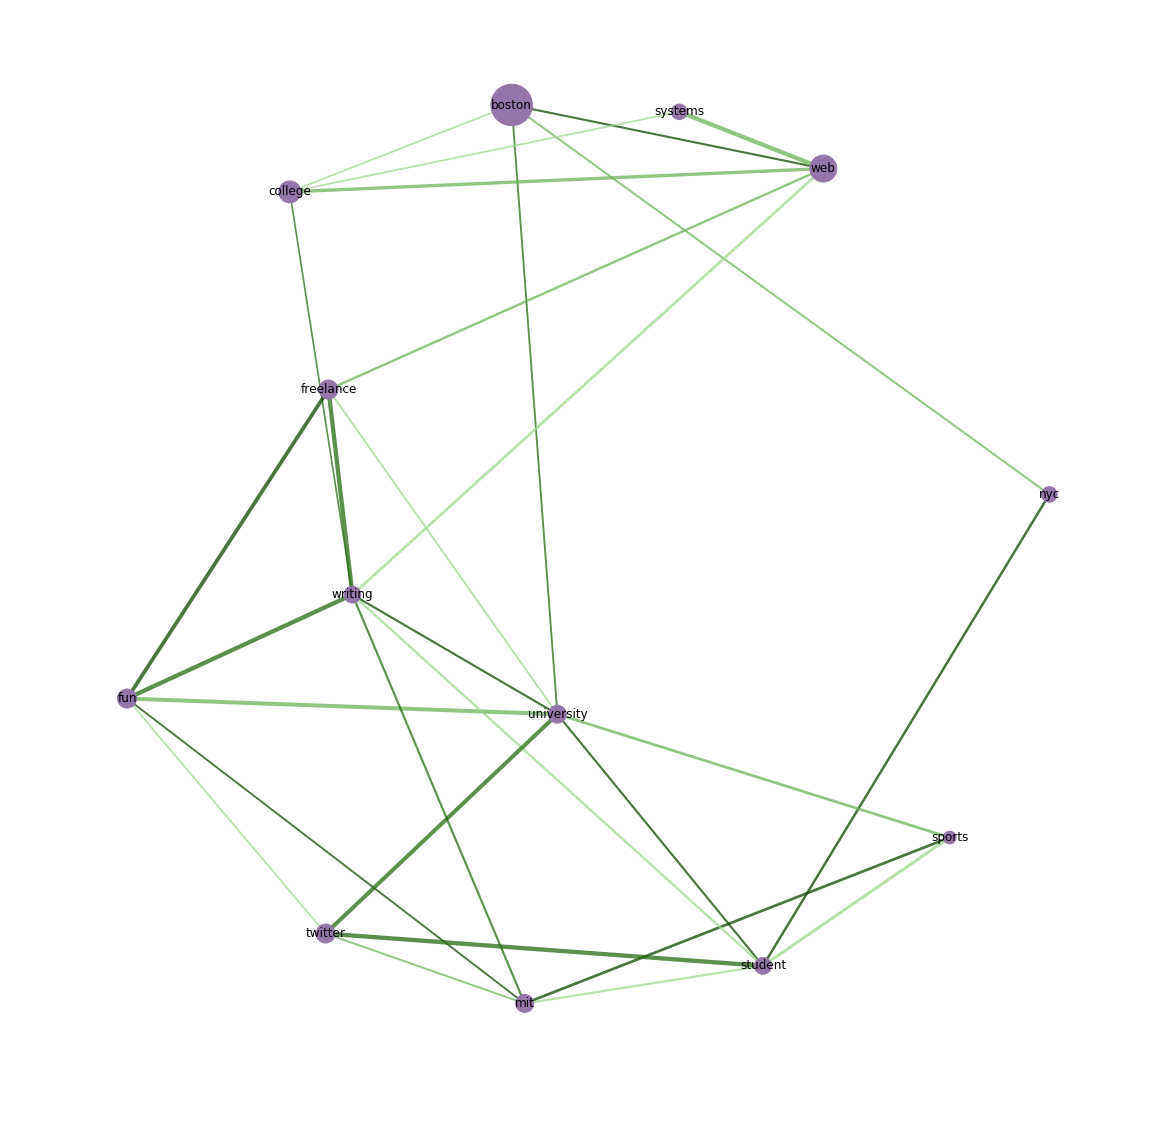

In [14]:
subset = [ 'boston',
 'college',
 'freelance',
 'fun',
 'mit',
 'nyc',
 'sports',
 'student',
 'systems',
 'twitter',
 'university',
 'web',
 'writing']
words = getWordsDict(subset)
G = makeGraph(subset, words, edge_threshold=0.05)
drawGraph(G, words)
plt.show()

Thanks for reading!